In [1]:
'''
构造raw_data，等同于prepare_align.py
'''
import os
import sys
import argparse
import json
import yaml
import librosa
import numpy as np
from scipy.io import wavfile

sys.path.append('/home/you/workspace/son/FastSpeech2')
from text import _clean_text


def split_json_by_splitset(input_file, output_dir):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Load the JSON file
    with open(input_file, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # Group data by Split_Set
    split_data = {}
    for key, value in data.items():
        split_set = value.get("Split_Set", "Unknown")
        if split_set not in split_data:
            split_data[split_set] = {}
        split_data[split_set][key] = value

    # Save each group to a separate JSON file
    for split_set, items in split_data.items():
        output_file = os.path.join(output_dir, f"{split_set}.json")
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(items, f, indent=4, ensure_ascii=False)

    print(f"Data has been split and saved into {output_dir}")


def copy_files_from_list(config, part_file):
    in_dir = config["path"]["corpus_path"]
    out_dir = config["path"]["raw_path"]
    sampling_rate = config["preprocessing"]["audio"]["sampling_rate"]
    max_wav_value = config["preprocessing"]["audio"]["max_wav_value"]
    cleaners = config["preprocessing"]["text"]["text_cleaners"]
    data_part_path = os.path.join(in_dir, 'Labels', part_file)
    if not os.path.exists(data_part_path):
        split_json_by_splitset(os.path.join(in_dir, 'Labels', 'labels_consensus.json'), os.path.join(in_dir, 'Labels'))
    
    
    # Ensure output directories exist
    os.makedirs(out_dir, exist_ok=True)

    # Load the JSON file
    with open(data_part_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # Get the list of keys (audio file names)
    for audio_file, metadata in data.items():
        speaker_id = metadata.get("SpkrID", "unknown")
        speaker_folder = os.path.join(out_dir, speaker_id)
        os.makedirs(speaker_folder, exist_ok=True)
    
        wav_path = os.path.join(os.path.join(in_dir, 'Audios'), audio_file)
        if os.path.exists(wav_path):
            wav, _ = librosa.load(wav_path, sampling_rate)
            epsilon = 1e-6  # 小常数，防止分母过小
            wav = wav / (np.max(np.abs(wav)) + epsilon) * max_wav_value
            wav_output_path = os.path.join(speaker_folder, audio_file)
            wavfile.write(wav_output_path, sampling_rate, wav.astype(np.int16))
        
        base_name = os.path.splitext(audio_file)[0]
        transcript_file = base_name + '.txt'
        transcript_path = os.path.join(os.path.join(in_dir, 'Transcripts'), transcript_file)
        if os.path.exists(transcript_path):
            with open(transcript_path, 'r', encoding='utf-8') as f:
                text = f.read()
            cleaned_text = _clean_text(text, cleaners)
            transcript_output_path = os.path.join(speaker_folder, base_name + ".lab")
            with open(transcript_output_path, 'w', encoding='utf-8') as f:
                f.write(cleaned_text)

    print(f"Files have been copied to {out_dir}")
        
        

config = yaml.load(open('/home/you/workspace/son/FastSpeech2/config/MSP/preprocess.yaml', "r"), Loader=yaml.FullLoader)
part_files = ['Development.json', 'Train.json', 'Test1.json', 'Test2.json']
part_file = part_files[1]
copy_files_from_list(config, part_file)
# if __name__ == "__main__":
#     parser = argparse.ArgumentParser()
#     parser.add_argument("config", type=str, help="path to preprocess.yaml")
#     args = parser.parse_args()

#     config = yaml.load(open(args.config, "r"), Loader=yaml.FullLoader)
#     copy_files_from_list(config)

Files have been copied to /home/you/workspace/son/FastSpeech2/raw_data/MSP


In [2]:
import shutil
import yaml, json
def trans_textgrid(config, part_file):
    '''
    part_file对应的textgrid文件转移到/home/you/workspace/son/FastSpeech2/preprocessed_data/MSP
    '''
    in_dir = config["path"]["corpus_path"]
    out_dir = config["path"]["preprocessed_path"]
    out_dir = os.path.join(out_dir, 'TextGrid')
    data_part_path = os.path.join(in_dir, 'Labels', part_file)
    if not os.path.exists(data_part_path):
        split_json_by_splitset(os.path.join(in_dir, 'Labels', 'labels_consensus.json'), os.path.join(in_dir, 'Labels'))
    # Ensure output directories exist
    os.makedirs(out_dir, exist_ok=True)
    # Load the JSON file
    with open(data_part_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    for audio_file, metadata in data.items():
        speaker_id = metadata.get("SpkrID", "unknown")
        speaker_folder = os.path.join(out_dir, speaker_id)
        os.makedirs(speaker_folder, exist_ok=True)
        base_name = os.path.splitext(audio_file)[0]
        textgrid_file_name = base_name + '.TextGrid'
        textgrid_path = os.path.join(os.path.join(in_dir, 'ForceAligned'), textgrid_file_name)
        if os.path.exists(textgrid_path):
            shutil.copy(textgrid_path, os.path.join(speaker_folder, textgrid_file_name))
        

config = yaml.load(open('/home/you/workspace/son/FastSpeech2/config/MSP/preprocess.yaml', "r"), Loader=yaml.FullLoader)
trans_textgrid(config, part_file)

In [3]:
'''
textgrid文件有些是空的，会导致preprocess.py报错，这里检测并处理。
'''
import os
import tgt

# 输入路径
textgrid_folder = "/home/you/workspace/son/FastSpeech2/preprocessed_data/MSP/TextGrid"
raw_data_folder = "/home/you/workspace/son/FastSpeech2/raw_data"

n = 0
for root, dirs, files in os.walk(textgrid_folder):
    for file in files:
        tg_path = os.path.join(root, file)
        try:
            # 尝试读取 TextGrid 文件
            textgrid = tgt.io.read_textgrid(tg_path)
        except Exception as e:
            # 处理错误
            print(f"Error processing TextGrid: {tg_path}")
            
            # 删除出错的 TextGrid 文件
            os.remove(tg_path)
            print(f"Deleted TextGrid: {tg_path}")
            
            # 提取 basename 和 spkrID
            basename = os.path.splitext(file)[0]
            spkrID = os.path.basename(root)  # 获取上级目录名作为 spkrID
            
            # 构造对应的 .wav 和 .lab 文件路径
            wav_path = os.path.join(raw_data_folder, 'MSP', spkrID, f"{basename}.wav")
            lab_path = os.path.join(raw_data_folder, 'MSP', spkrID, f"{basename}.lab")
            
            # 删除 .wav 文件
            if os.path.exists(wav_path):
                os.remove(wav_path)
                print(f"Deleted WAV: {wav_path}")
            
            # 删除 .lab 文件
            if os.path.exists(lab_path):
                os.remove(lab_path)
                print(f"Deleted LAB: {lab_path}")
            
            n += 1
print(n)


Error processing TextGrid: /home/you/workspace/son/FastSpeech2/preprocessed_data/MSP/TextGrid/3258/MSP-PODCAST_5730_1301.TextGrid
Deleted TextGrid: /home/you/workspace/son/FastSpeech2/preprocessed_data/MSP/TextGrid/3258/MSP-PODCAST_5730_1301.TextGrid
Deleted WAV: /home/you/workspace/son/FastSpeech2/raw_data/MSP/3258/MSP-PODCAST_5730_1301.wav
Deleted LAB: /home/you/workspace/son/FastSpeech2/raw_data/MSP/3258/MSP-PODCAST_5730_1301.lab
Error processing TextGrid: /home/you/workspace/son/FastSpeech2/preprocessed_data/MSP/TextGrid/2430/MSP-PODCAST_5748_0066.TextGrid
Deleted TextGrid: /home/you/workspace/son/FastSpeech2/preprocessed_data/MSP/TextGrid/2430/MSP-PODCAST_5748_0066.TextGrid
Deleted WAV: /home/you/workspace/son/FastSpeech2/raw_data/MSP/2430/MSP-PODCAST_5748_0066.wav
Deleted LAB: /home/you/workspace/son/FastSpeech2/raw_data/MSP/2430/MSP-PODCAST_5748_0066.lab
Error processing TextGrid: /home/you/workspace/son/FastSpeech2/preprocessed_data/MSP/TextGrid/3234/MSP-PODCAST_5718_0589.TextG

In [4]:
'''获取最长序列长度'''
import os
import librosa

def get_max_seqlength(audio_folder, sampling_rate=22050):
    max_length = 0  # 最大序列长度
    max_file = None  # 最大文件名

    for root, dirs, files in os.walk(audio_folder):  # 遍历所有目录和次级目录
        for file in files:
            if file.endswith(".wav"):  # 只处理 .wav 文件
                file_path = os.path.join(root, file)  # 获取完整路径
                try:
                    # 加载音频文件
                    wav, sr = librosa.load(file_path, sr=sampling_rate)
                    length = len(wav)  # 获取采样点数
                    if length > max_length:
                        max_length = length
                        max_file = file_path
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

    # 转换为秒（可选）
    max_length_in_seconds = max_length / sampling_rate

    print(f"Max sequence length: {max_length} samples ({max_length_in_seconds:.2f} seconds)")
    print(f"Longest file: {max_file}")

# 使用示例
audio_folder = "/home/you/workspace/son/FastSpeech2/raw_data/MSP"  # 顶级目录
get_max_seqlength(audio_folder, sampling_rate=22050)


Max sequence length: 247042 samples (11.20 seconds)
Longest file: /home/you/workspace/son/FastSpeech2/raw_data/MSP/67/MSP-PODCAST_0285_0018.wav


In [5]:
'''删除非ARPAbet音素的textgrid文件'''
import os
import re
import tgt

# ARPAbet音素的正则表达式
ARPABET_PATTERN = re.compile(r"^[A-Z]+[0-2]?$")  # 大写字母+可选的重音数字（0, 1, 2）

def is_arpabet_sequence(text):
    """
    判断给定文本是否是有效的 ARPAbet 音素
    """
    return ARPABET_PATTERN.match(text) is not None

def delete_non_arpabet_textgrids(textgrid_folder):
    """
    删除 `phones` 层级中包含非 ARPAbet 音素序列的 TextGrid 文件
    """
    for root, dirs, files in os.walk(textgrid_folder):
        num = 0
        for file in files:
            if file.endswith(".TextGrid"):
                tg_path = os.path.join(root, file)
                try:
                    # 加载 TextGrid 文件
                    textgrid = tgt.io.read_textgrid(tg_path)
                    
                    # 检查是否存在 "phones" 层级
                    if "phones" in textgrid.get_tier_names():
                        tier = textgrid.get_tier_by_name("phones")
                        # phones = get_alignment(tier)
                        # print(phones)
                        # 遍历所有间隔，检查是否存在非 ARPAbet 音素
                        contains_non_arpabet = any(
                            not is_arpabet_sequence(interval.text.strip()) for interval in tier.intervals if interval.text.strip()
                        )
                        
                        if contains_non_arpabet:
                            # print(f"Deleting file with non-ARPAbet phonemes: {tg_path}")
                            os.remove(tg_path)
                            # 提取 basename 和 spkrID
                            basename = os.path.splitext(file)[0]
                            spkrID = os.path.basename(root)  # 获取上级目录名作为 spkrID
                            
                            # 构造对应的 .wav 和 .lab 文件路径
                            wav_path = os.path.join(raw_data_folder, 'MSP', spkrID, f"{basename}.wav")
                            lab_path = os.path.join(raw_data_folder, 'MSP', spkrID, f"{basename}.lab")
                            
                            # 删除 .wav 文件
                            if os.path.exists(wav_path):
                                os.remove(wav_path)
                                # print(f"Deleted WAV: {wav_path}")
                            
                            # 删除 .lab 文件
                            if os.path.exists(lab_path):
                                os.remove(lab_path)
                                # print(f"Deleted LAB: {lab_path}")
                            num += 1
                except Exception as e:
                    print(f"Error processing {tg_path}: {e}")
    
    print(f"Deleted {num} non-ARPAbet TextGrid files.")


def get_alignment(tier):
    sil_phones = ["sil", "sp", "spn"]

    phones = []
    for t in tier._objects:
        s, e, p = t.start_time, t.end_time, t.text

        # Trim leading silences
        if phones == []:
            if p in sil_phones:
                continue
            else:
                start_time = s

        if p not in sil_phones:
            # For ordinary phones
            phones.append(p)
            end_time = e
            end_idx = len(phones)
        else:
            # For silent phones
            phones.append(p)

    # Trim tailing silences
    phones = phones[:end_idx]

    return phones

# 使用示例
textgrid_folder = "/home/you/workspace/son/FastSpeech2/preprocessed_data/MSP/TextGrid/"
delete_non_arpabet_textgrids(textgrid_folder)


Deleted 0 non-ARPAbet TextGrid files.


In [5]:
'''生成train_labels.json'''
import os
import pandas as pd
import json

# ======== 修改为你的实际路径 ========
audio_root = "/home/you/workspace/son/FastSpeech2/raw_data/MSP"         # wav 所在目录（包含子目录）
csv_path = "/home/you/workspace/database/MSP/Labels/labels_consensus.csv"             # 图1对应的CSV路径
json_out_path = "/home/you/workspace/son/FastSpeech2/preprocessed_data/MSP/train_labels.json"          # 输出json文件名
# ====================================

# 1. 获取所有 .wav 文件名（不带扩展名）
wav_basenames = []
for root, _, files in os.walk(audio_root):
    for file in files:
        if file.endswith(".wav"):
            wav_basenames.append(file)

# 2. 加载 CSV，按 FileName 筛选
df = pd.read_csv(csv_path)

# 3. 筛选 CSV 中出现在 .wav 文件中的行
filtered_df = df[df["FileName"].isin(wav_basenames)]

# 4. 转为字典形式，以 FileName 为键
result_dict = filtered_df.set_index("FileName").T.to_dict()

# 5. 保存为 JSON
with open(json_out_path, "w", encoding="utf-8") as f:
    json.dump(result_dict, f, indent=4, ensure_ascii=False)

print(f"完成！共筛选出 {len(result_dict)} 条记录，已保存到：{json_out_path}")


完成！共筛选出 54786 条记录，已保存到：/home/you/workspace/son/FastSpeech2/preprocessed_data/MSP/train_labels.json


In [ ]:
'''从train_labels.json提取emotions.json '''
import json
import os
import numpy as np

def generate_emotions_json(train_labels_path, output_path):
    # 读取train_labels.json
    labels_path = train_labels_path
    with open(labels_path, 'r', encoding='utf-8') as f:
        labels = json.load(f)
    
    # 初始化情绪字典
    emotions = set()
    arousals = []
    valences = []
    
    # 从标签中提取情绪信息
    for _, label in labels.items():
        # 情绪类型
        if 'EmoClass' in label:
            emotions.add(label['EmoClass'])
        # 唤醒度 (EmoAct)
        if 'EmoAct' in label:
            arousals.append(float(label['EmoAct']))
        # 效价 (EmoVal)
        if 'EmoVal' in label:
            valences.append(float(label['EmoVal']))
    
    # 创建情绪类型映射字典
    emotion_dict = {emotion: idx for idx, emotion in enumerate(sorted(emotions))}
    
    # 对唤醒度和效价进行分箱处理
    n_bins = 14  # 与模型配置保持一致
    arousal_min, arousal_max = min(arousals), max(arousals)
    valence_min, valence_max = min(valences), max(valences)
    
    # 创建分箱边界
    arousal_bins = np.linspace(arousal_min, arousal_max, n_bins-1)
    valence_bins = np.linspace(valence_min, valence_max, n_bins-1)
    
    # 创建映射字典
    arousal_dict = {str(round(bin_val, 1)): idx for idx, bin_val in enumerate(arousal_bins)}
    valence_dict = {str(round(bin_val, 1)): idx for idx, bin_val in enumerate(valence_bins)}
    
    # 组合成最终的emotions.json结构
    emotions_json = {
        "emotion_dict": emotion_dict,
        "arousal_dict": arousal_dict,
        "valence_dict": valence_dict,
        "arousal_bins": arousal_bins.tolist(),  # 保存分箱边界，供后续使用
        "valence_bins": valence_bins.tolist()   # 保存分箱边界，供后续使用
    }
    
    # 保存到emotions.json
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(emotions_json, f, indent=2)
    
    print(f"已生成 emotions.json，包含：")
    print(f"- 情绪类型数量: {len(emotion_dict)}")
    print(f"- 唤醒度分箱数量: {len(arousal_dict)}")
    print(f"- 效价分箱数量: {len(valence_dict)}")
    print(f"\n唤醒度范围: [{arousal_min:.1f}, {arousal_max:.1f}]")
    print(f"效价范围: [{valence_min:.1f}, {valence_max:.1f}]")

if __name__ == "__main__":
    train_labels_path = '/home/you/workspace/son/FastSpeech2/preprocessed_data/MSP/train_labels.json'
    output_path = '/home/you/workspace/son/FastSpeech2/preprocessed_data/MSP/emotions.json'
    generate_emotions_json(train_labels_path, output_path) 

In [1]:
'''生成添加了情绪信息的train/val.txt'''
import json
import os
import shutil

def round_half(x):
    return round(x * 2) / 2

# ======= 修改路径为你的真实路径 =======
base_path = "/home/you/workspace/son/FastSpeech2/preprocessed_data/MSP_clean_new"
train_path = os.path.join(base_path, "train.txt")
val_path = os.path.join(base_path, "val.txt")
train_labels_path = os.path.join(base_path, "train_labels.json")
# =====================================

# 备份原始文件
if os.path.exists(train_path):
    shutil.copy2(train_path, os.path.join(base_path, "train_original.txt"))
if os.path.exists(val_path):
    shutil.copy2(val_path, os.path.join(base_path, "val_original.txt"))

# 读取 JSON 数据
with open(train_labels_path, "r", encoding="utf-8") as f:
    emotion_data = json.load(f)

def process_emotion_file(input_path, output_path, emotion_data):
    """处理情绪标注文件
    
    Args:
        input_path (str): 输入文件路径(train_original.txt或val_original.txt)
        output_path (str): 输出文件路径(train.txt或val.txt) 
        emotion_data (dict): 情绪标注数据
    """
    with open(input_path, "r", encoding="utf-8") as fin, open(output_path, "w", encoding="utf-8") as fout:
        for line in fin:
            line = line.strip()
            if not line:
                continue
            parts = line.split("|")
            if len(parts) < 3:
                continue

            utt_id = parts[0]
            wav_key = utt_id + ".wav"

            if wav_key in emotion_data:
                emo = emotion_data[wav_key]
                emo_class = emo.get("EmoClass", "NA")
                emo_act = emo.get("EmoAct", "NA")
                emo_val = emo.get("EmoVal", "NA")
                emo_act = round_half(emo.get("EmoAct", 0))
                emo_val = round_half(emo.get("EmoVal", 0))
                # 添加到行尾
                new_line = f"{line}|{emo_class}|{emo_act}|{emo_val}\n"
            else:
                # 如果不在 JSON 中，也保留原始行
                new_line = f"{line}|NA|NA|NA\n"
                print(f'{line}')

            fout.write(new_line)
    
    print(f"✅ 合并完成，输出保存至：{output_path}")

process_emotion_file(os.path.join(base_path, "train_original.txt"), train_path, emotion_data)
process_emotion_file(os.path.join(base_path, "val_original.txt"), val_path, emotion_data)


✅ 合并完成，输出保存至：/home/you/workspace/son/FastSpeech2/preprocessed_data/MSP_clean_new/train.txt
✅ 合并完成，输出保存至：/home/you/workspace/son/FastSpeech2/preprocessed_data/MSP_clean_new/val.txt


In [2]:
'''合并多个数据集的speakers.json'''
import json
import shutil
import os

def merge_speakers_json(datasets_info):
    """合并多个数据集的speakers.json文件
    
    Args:
        datasets_info (list): 包含数据集信息的列表，每个元素是一个字典:
            {
                'path': 数据集路径,
                'name': 数据集名称前缀
            }
    """
    merged_spk = {}
    cur_id = 0
    
    # 遍历每个数据集
    for dataset in datasets_info:
        dataset_path = dataset['preprocessed_path']
        prefix = dataset['name']
        speakers_path = os.path.join(dataset_path, 'speakers.json')
        
        # 如果是第二个及以后的数据集,先备份原始speakers.json
        if dataset != datasets_info[0]:
            original_path = os.path.join(dataset_path, 'original_speakers.json')
            shutil.move(speakers_path, original_path)
            speakers_path = original_path
            
        # 读取speakers.json
        with open(speakers_path) as f:
            spk_data = json.load(f)
            
        # 添加前缀并合并
        for name in spk_data:
            merged_spk[f"{prefix}_{name}"] = cur_id
            cur_id += 1
            
    # 保存到第2个数据集的目录下
    output_path = os.path.join(datasets_info[1]['preprocessed_path'], 'speakers.json')
    with open(output_path, "w") as f:
        json.dump(merged_spk, f, indent=4)
    print(f"✅ 已合并speakers.json并保存至: {output_path}")

# 使用示例:
datasets = [
    {
        'preprocessed_path': '/home/you/workspace/son/FastSpeech2/preprocessed_data/LibriTTS',
        'name': 'LibriTTS'
    },
    {
        'preprocessed_path': '/home/you/workspace/son/FastSpeech2/preprocessed_data/MSP_clean_new', 
        'name': 'MSP'
    }
]

merge_speakers_json(datasets)


✅ 已合并speakers.json并保存至: /home/you/workspace/son/FastSpeech2/preprocessed_data/MSP_clean_new/speakers.json


In [3]:
'''为speaker id添加前缀'''
import os

def add_prefix_to_speaker(line, dataset_name):
    parts = line.strip().split('|')
    if len(parts) >= 2:
        speaker_id = parts[1]
        if len(speaker_id.split('_')) > 1:
            speaker_id = speaker_id.split('_')[-1]
        # 根据数据集名称添加对应前缀
        parts[1] = f"{dataset_name}_{speaker_id}"
    return '|'.join(parts)

def process_file(file_path, prefix):
    temp_path = file_path + '.temp'
    
    with open(file_path, 'r', encoding='utf-8') as fin:
        with open(temp_path, 'w', encoding='utf-8') as fout:
            for line in fin:
                new_line = add_prefix_to_speaker(line, prefix)
                fout.write(new_line + '\n')
    
    # 替换原文件
    os.replace(temp_path, file_path)
    print(f"✅ 已完成{os.path.basename(file_path)}中{prefix}数据集的speaker id前缀添加")

# 要处理的文件列表
files_to_process = [
    "/home/you/workspace/son/FastSpeech2/preprocessed_data/MSP_clean_new/train.txt",
    "/home/you/workspace/son/FastSpeech2/preprocessed_data/MSP_clean_new/val.txt"
    # "/home/you/workspace/son/FastSpeech2/preprocessed_data/LibriTTS/train.txt",
    # "/home/you/workspace/son/FastSpeech2/preprocessed_data/LibriTTS/val.txt"
]
prefix = "MSP"

# 批量处理所有文件
for file_path in files_to_process:
    if os.path.exists(file_path):
        process_file(file_path, prefix)
    else:
        print(f"⚠️ 文件不存在: {file_path}")




✅ 已完成train.txt中MSP数据集的speaker id前缀添加
✅ 已完成val.txt中MSP数据集的speaker id前缀添加


In [3]:
'''UTMOS分数计算'''
# @title 🔄 Load SpeechMOS predictor
import torch, glob, os, librosa
import numpy as np
from typing import Optional
import csv
import torch
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
predictor = torch.hub.load(
    "tarepan/SpeechMOS:v1.2.0",
    "utmos22_strong",
).to(device).eval()

def calc_speechmos(wav_path: str, sr_target: Optional[int] = None) -> float:
    """Return MOS score of a wav using UTMOS (SpeechMOS)."""
    wav, sr = librosa.load(wav_path, sr=sr_target, mono=True)
    wav_t = torch.from_numpy(wav).unsqueeze(0).to(device)
    with torch.inference_mode():
        score = predictor(wav_t, sr).item()
    return float(score)

def find_wav_files(folder: str) -> list:
    """递归查找所有 .wav 文件"""
    wav_files = []
    for root, _, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(".wav"):
                wav_files.append(os.path.join(root, file))
    return wav_files

def main(input_folder: str, output_csv: str):
    wav_list = find_wav_files(input_folder)
    print(f"✅ 共找到 {len(wav_list)} 个 wav 文件，开始评估...")

    results = []
    for wav_path in tqdm(wav_list):
        try:
            score = calc_speechmos(wav_path)
            results.append([wav_path, round(score, 4)])
        except Exception as e:
            print(f"❌ 处理失败: {wav_path}, 错误: {e}")
            results.append([wav_path, "error"])

    # 写入 CSV 文件
    with open(output_csv, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["wav_path", "utmos_score"])
        writer.writerows(results)

    print(f"🎉 写入完成，结果保存在: {output_csv}")

if __name__ == "__main__":

    input_dir = "/home/you/workspace/son/FastSpeech2/raw_data/MSP"
    output_csv = "/home/you/workspace/son/FastSpeech2/preprocessed_data/MSP/utmos_scores.csv"

    main(input_dir, output_csv)



Using cache found in /home/you/.cache/torch/hub/tarepan_SpeechMOS_v1.2.0
  0%|          | 2/54786 [00:00<1:00:22, 15.12it/s]

✅ 共找到 54786 个 wav 文件，开始评估...


100%|██████████| 54786/54786 [45:15<00:00, 20.17it/s]

🎉 写入完成，结果保存在: /home/you/workspace/son/FastSpeech2/preprocessed_data/MSP/utmos_scores.csv


全部数据分析:
基本统计信息:
count    54786.000000
mean         2.845626
std          0.817324
min          1.222000
25%          2.279000
50%          2.940400
75%          3.483700
max          4.491900
Name: utmos_score, dtype: float64


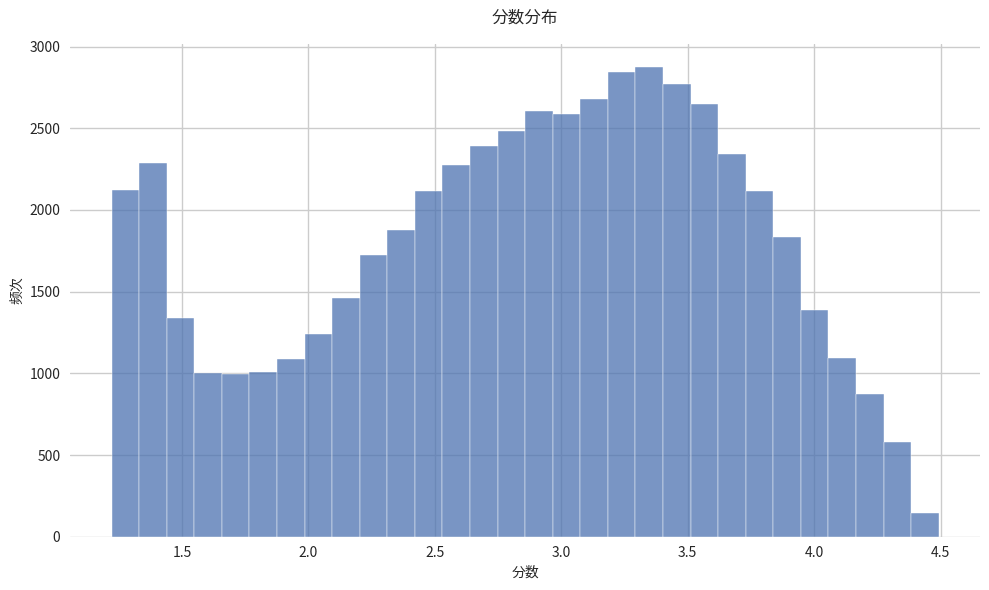

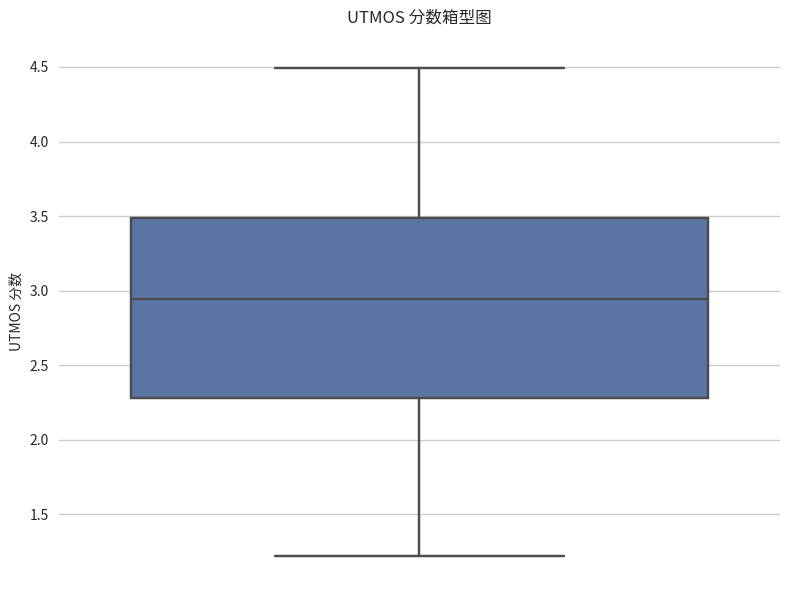


异常值数量: 0
异常值范围: < 0.47 或 > 5.29

分数区间统计:
0-1分        0
1-2分    10015
2-3分    18788
3-4分    22594
4-5分     3389
Name: score_range, dtype: int64


高质量数据分析(MOS>2.9):
基本统计信息:
count    28347.000000
mean         3.502072
std          0.375745
min          2.900000
25%          3.193000
50%          3.464900
75%          3.776200
max          4.491900
Name: utmos_score, dtype: float64


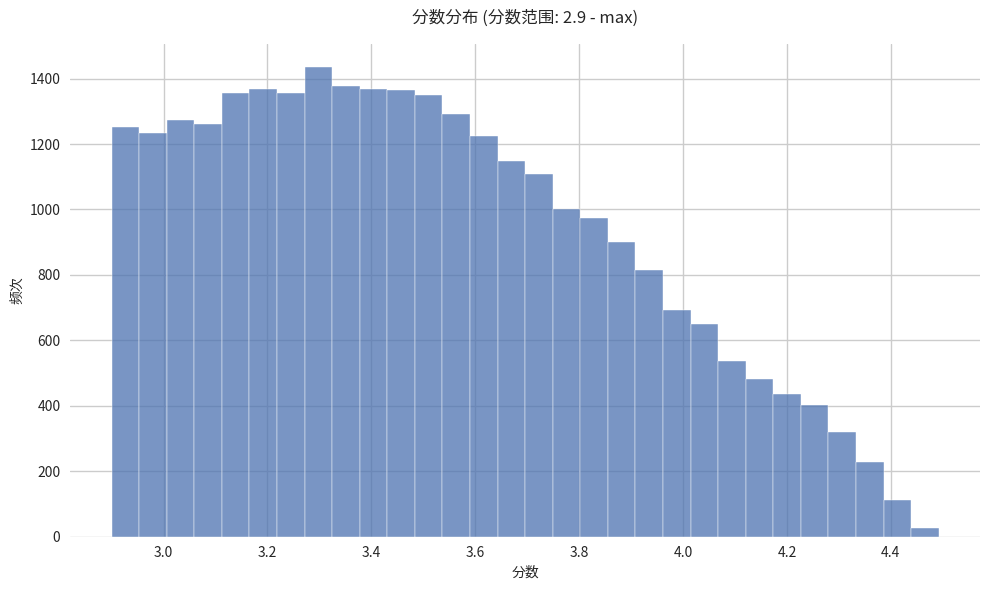

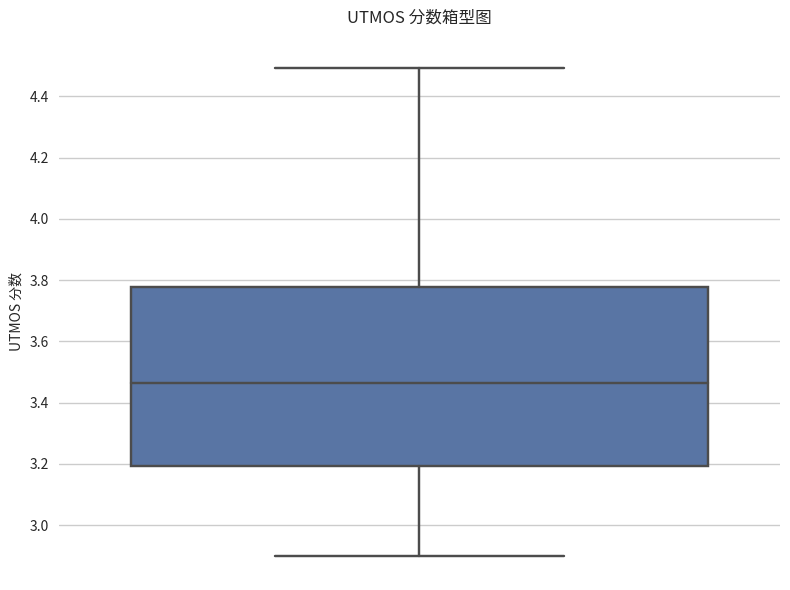


异常值数量: 0
异常值范围: < 2.32 或 > 4.65

分数区间统计:
0-1分        0
1-2分        0
2-3分     2364
3-4分    22594
4-5分     3389
Name: score_range, dtype: int64


/home/you/anaconda3/envs/fs2/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
'''UTMOS分数统计'''
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

def analyze_utmos_scores(df, min_score=None, max_score=None):
    """按分数范围分析UTMOS分数
    
    Args:
        df: 包含utmos_score的DataFrame
        min_score: 最小分数阈值(可选)
        max_score: 最大分数阈值(可选)
    """
    # 根据分数范围筛选数据
    if min_score is not None:
        df = df[df['utmos_score'] >= min_score]
    if max_score is not None:
        df = df[df['utmos_score'] <= max_score]
        
    # 基本统计信息
    print("基本统计信息:")
    print(df['utmos_score'].describe())

    # 设置图表样式
    plt.style.use('seaborn')
    sns.set_style("whitegrid")
    plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP']
    plt.rcParams['axes.unicode_minus'] = False

    # 绘制分布图
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='utmos_score', bins=30)
    title = '分数分布'
    if min_score is not None or max_score is not None:
        title += f' (分数范围: {min_score if min_score else "min"} - {max_score if max_score else "max"})'
    plt.title(title, fontsize=12, pad=15)
    plt.xlabel('分数', fontsize=10)
    plt.ylabel('频次', fontsize=10)
    plt.tight_layout()
    plt.show()

    # 绘制箱型图
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=df['utmos_score'])
    plt.title('UTMOS 分数箱型图', fontsize=12, pad=15)
    plt.ylabel('UTMOS 分数', fontsize=10)
    plt.tight_layout()
    plt.show()

    # 计算异常值界限
    Q1 = df['utmos_score'].quantile(0.25)
    Q3 = df['utmos_score'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 输出异常值信息
    outliers = df[(df['utmos_score'] < lower_bound) | (df['utmos_score'] > upper_bound)]
    print(f"\n异常值数量: {len(outliers)}")
    print(f"异常值范围: < {lower_bound:.2f} 或 > {upper_bound:.2f}")

    # 输出分数区间统计
    print("\n分数区间统计:")
    bins = [0, 1, 2, 3, 4, 5]
    labels = ['0-1分', '1-2分', '2-3分', '3-4分', '4-5分']
    df['score_range'] = pd.cut(df['utmos_score'], bins=bins, labels=labels, right=False)
    print(df['score_range'].value_counts().sort_index())


# 读取CSV文件
df = pd.read_csv('/home/you/workspace/son/FastSpeech2/preprocessed_data/MSP/utmos_scores.csv')

# 分析全部数据
print("全部数据分析:")
analyze_utmos_scores(df)

# 分析高质量数据(MOS>2.9)
min_score = 2.9
print(f"\n\n高质量数据分析(MOS>{min_score}):")
analyze_utmos_scores(df, min_score=min_score)


In [8]:
# from moviepy.video.tools.subtitles import SubtitlesClip
import PIL.ImageFont as ImageFont
import os

font_paths = [f for f in os.listdir("/usr/share/fonts") if f.endswith(".ttc")]
for path in font_paths:
    try:
        font = ImageFont.truetype(path, 20)
        print(path)
    except:
        continue


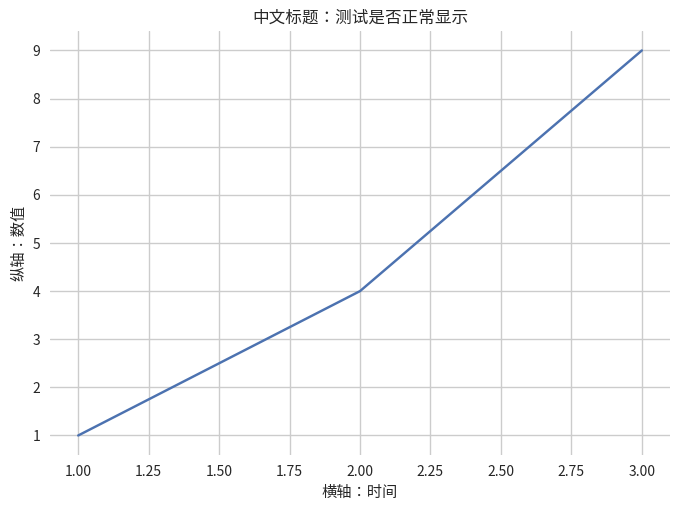

['Noto Serif CJK JP', 'Noto Sans CJK JP', 'Noto Sans CJK JP', 'Noto Sans CJK JP', 'Noto Serif CJK JP', 'Noto Serif CJK JP', 'Noto Serif CJK JP', 'Noto Sans CJK JP', 'Noto Mono', 'Noto Serif CJK JP', 'Noto Sans CJK JP', 'Noto Sans CJK JP', 'Noto Serif CJK JP', 'Noto Serif CJK JP', 'Noto Sans CJK JP']


In [3]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP']  # 换成你实际安装的字体名
plt.rcParams['axes.unicode_minus'] = False

plt.plot([1, 2, 3], [1, 4, 9])
plt.title("中文标题：测试是否正常显示")
plt.xlabel("横轴：时间")
plt.ylabel("纵轴：数值")
plt.show()

import matplotlib.font_manager as fm
fonts = [f.name for f in fm.fontManager.ttflist]
print([f for f in fonts if 'Noto' in f or 'Hei' in f or 'YaHei' in f or 'Sim' in f])



In [7]:
'''复制高质量数据到raw_data和preprocessed_data'''
import shutil
import os
import pandas as pd
# 创建MSP_clean目录
clean_data_dir = "/home/you/workspace/son/FastSpeech2/raw_data/MSP_clean"
if not os.path.exists(clean_data_dir):
    os.makedirs(clean_data_dir)

# 获取评分大于2.9的数据
# 从之前的评分结果中读取数据
df = pd.read_csv('/home/you/workspace/son/FastSpeech2/preprocessed_data/MSP/utmos_scores.csv')
high_quality_data = df[df['utmos_score'] > 2.9]
print(f"\n评分大于2.9的数据数量: {len(high_quality_data)}")

# 复制高质量数据到新目录
source_dir = "/home/you/workspace/son/FastSpeech2/raw_data/MSP"
target_dir = clean_data_dir
tg_source_dir = '/home/you/workspace/son/FastSpeech2/preprocessed_data/MSP/TextGrid'
tg_target_dir = '/home/you/workspace/son/FastSpeech2/preprocessed_data/MSP_clean/TextGrid'

# 获取所有说话人文件夹
speaker_dirs = set()
for _, row in high_quality_data.iterrows():
    wav_file = row['wav_path']
    speaker_dir = wav_file.split('/')[-2]
    speaker_dirs.add(speaker_dir)

# 先创建所有说话人文件夹
for speaker_dir in speaker_dirs:
    os.makedirs(os.path.join(target_dir, speaker_dir), exist_ok=True)
    os.makedirs(os.path.join(tg_target_dir, speaker_dir), exist_ok=True)
# 复制文件
copied_count = 0
for _, row in high_quality_data.iterrows():
    wav_path = row['wav_path']
    speaker = wav_path.split('/')[-2]
    wav_basename = os.path.basename(wav_path).split('.')[0]
    
    source_path = os.path.join(source_dir, speaker, wav_basename + '.wav')
    target_path = os.path.join(target_dir, speaker, wav_basename + '.wav')
    shutil.copy2(source_path, target_path)

    source_path = os.path.join(source_dir, speaker, wav_basename + '.lab')
    target_path = os.path.join(target_dir, speaker, wav_basename + '.lab')
    shutil.copy2(source_path, target_path)

    source_path = os.path.join(tg_source_dir, speaker, wav_basename + '.TextGrid')
    target_path = os.path.join(tg_target_dir, speaker, wav_basename + '.TextGrid')
    shutil.copy2(source_path, target_path)

    copied_count += 1
    
    if copied_count % 1000 == 0:
        print(f"已复制 {copied_count} 个文件...")
print(f"\n完成! 共复制了 {copied_count} 个高质量音频文件到 {target_dir}")
print(f"共创建了 {len(speaker_dirs)} 个说话人文件夹")



评分大于2.9的数据数量: 28344
已复制 1000 个文件...
已复制 2000 个文件...
已复制 3000 个文件...
已复制 4000 个文件...
已复制 5000 个文件...
已复制 6000 个文件...
已复制 7000 个文件...
已复制 8000 个文件...
已复制 9000 个文件...
已复制 10000 个文件...
已复制 11000 个文件...
已复制 12000 个文件...
已复制 13000 个文件...
已复制 14000 个文件...
已复制 15000 个文件...
已复制 16000 个文件...
已复制 17000 个文件...
已复制 18000 个文件...
已复制 19000 个文件...
已复制 20000 个文件...
已复制 21000 个文件...
已复制 22000 个文件...
已复制 23000 个文件...
已复制 24000 个文件...
已复制 25000 个文件...
已复制 26000 个文件...
已复制 27000 个文件...
已复制 28000 个文件...

完成! 共复制了 28344 个高质量音频文件到 /home/you/workspace/son/FastSpeech2/raw_data/MSP_clean
共创建了 1190 个说话人文件夹


In [3]:
import os
import shutil
from collections import defaultdict
import matplotlib.pyplot as plt

def analyze_speaker_samples(data_dir):
    """统计每个说话人的有效样本数量分布
    
    Args:
        data_dir: MSP数据集根目录
    Returns:
        speaker_counts: 每个说话人的样本数量字典
    """
    print(f"开始统计说话人样本数量分布...")
    
    # 用字典记录每个说话人的样本数
    speaker_counts = defaultdict(int)
    
    # 记录样本最多的说话人
    max_samples_speaker = None
    max_samples = 0
    
    # 遍历说话人文件夹
    for speaker in os.listdir(data_dir):
        speaker_dir = os.path.join(data_dir, speaker)
        
        # 确保是文件夹
        if not os.path.isdir(speaker_dir):
            continue
            
        # 统计音频文件和对应的lab文件数量
        wav_files = set(f[:-4] for f in os.listdir(speaker_dir) if f.endswith('.wav'))
        lab_files = set(f[:-4] for f in os.listdir(speaker_dir) if f.endswith('.lab'))
        
        # 找到同时具有wav和lab的文件
        valid_samples = wav_files & lab_files
        num_samples = len(valid_samples)

        # 更新最大样本数的说话人
        if num_samples > max_samples:
            max_samples = num_samples
            max_samples_speaker = speaker
        
        speaker_counts[speaker] = num_samples

    # 打印样本最多的说话人
    print(f"\n样本最多的说话人: {max_samples_speaker}, 样本数: {max_samples}")
    
    # 打印统计信息
    print("\n样本数量分布:")
    print(f"说话人总数: {len(speaker_counts)}")
    print(f"最大样本数: {max(speaker_counts.values())}")
    print(f"最小样本数: {min(speaker_counts.values())}")
    print(f"平均样本数: {sum(speaker_counts.values())/len(speaker_counts):.2f}")
    
    # 按样本数分组统计
    ranges = [(0,10), (10,50), (50,100), (100,200), (200,float('inf'))]
    range_counts = defaultdict(int)
    for count in speaker_counts.values():
        for low,high in ranges:
            if low <= count < high:
                range_counts[f"{low}-{high}"] += 1
                break
    
    print("\n样本数量区间分布:")
    for range_str, count in range_counts.items():
        print(f"样本数 {range_str}: {count}个说话人")
        
    # # 绘制分布图
    # plt.figure(figsize=(10,6))
    # labels = list(range_counts.keys())
    # sizes = list(range_counts.values())
    # plt.pie(sizes, labels=labels, autopct='%1.1f%%')
    # plt.title('Distribution of Samples per Speaker')
    # plt.axis('equal')
    # plt.show()
    
    # # 绘制柱状图
    # plt.figure(figsize=(10,6))
    # plt.bar(labels, sizes)
    # plt.title('Distribution of Samples per Speaker')
    # plt.xlabel('Sample Count Range')
    # plt.ylabel('Number of Speakers')
    # plt.xticks(rotation=45)
    # plt.show()

    # 计算每个区间的总音频数量
    range_samples = defaultdict(int)
    total_samples = 0
    for speaker, count in speaker_counts.items():
        total_samples += count
        for low,high in ranges:
            if low <= count < high:
                range_samples[f"{low}-{high}"] += count
                break
                
    print("\n各区间音频数量分布:")
    for range_str, samples in range_samples.items():
        percentage = samples / total_samples * 100
        print(f"样本数 {range_str}: {samples}条音频, 占比{percentage:.1f}%")
        
    # # 绘制音频数量分布饼图
    # plt.figure(figsize=(10,6))
    # labels = list(range_samples.keys())
    # sizes = list(range_samples.values())
    # plt.pie(sizes, labels=labels, autopct='%1.1f%%')
    # plt.title('Distribution of Total Audio Samples')
    # plt.axis('equal')
    # plt.show()
    
    # # 绘制音频数量分布柱状图
    # plt.figure(figsize=(10,6))
    # plt.bar(labels, sizes)
    # plt.title('Distribution of Total Audio Samples')
    # plt.xlabel('Sample Count Range')
    # plt.ylabel('Number of Audio Files')
    # plt.xticks(rotation=45)
    # plt.show()
    return speaker_counts

def remove_small_speaker_dirs(data_dir, min_samples=10):
    """删除样本数量少于阈值的说话人文件夹
    
    Args:
        data_dir: MSP数据集根目录
        min_samples: 最小样本数阈值,默认为10
    """
    print(f"\n开始清理说话人文件夹,最小样本数要求为{min_samples}")
    
    # 遍历说话人文件夹统计样本数
    for speaker in os.listdir(data_dir):
        speaker_dir = os.path.join(data_dir, speaker)
        
        # 确保是文件夹
        if not os.path.isdir(speaker_dir):
            continue
            
        # 统计音频文件和对应的lab文件数量
        wav_files = set(f[:-4] for f in os.listdir(speaker_dir) if f.endswith('.wav'))
        lab_files = set(f[:-4] for f in os.listdir(speaker_dir) if f.endswith('.lab'))
        
        # 找到同时具有wav和lab的文件
        valid_samples = wav_files & lab_files
        num_samples = len(valid_samples)
        
        # 根据样本数决定是否删除
        if num_samples < min_samples:
            print(f"删除说话人 {speaker}, 有效样本数={num_samples}")
            shutil.rmtree(speaker_dir)
        else:
            print(f"保留说话人 {speaker}, 有效样本数={num_samples}")
        

            
    print("清理完成")

# 示例调用方式:
data_dir = "/home/you/workspace/son/FastSpeech2/raw_data/MSP_clean"
# 只统计样本分布:
speaker_counts = analyze_speaker_samples(data_dir)
# 清理小样本说话人:
# remove_small_speaker_dirs(data_dir, min_samples=10)


开始统计说话人样本数量分布...

样本最多的说话人: Unknown, 样本数: 3384

样本数量分布:
说话人总数: 504
最大样本数: 3384
最小样本数: 10
平均样本数: 51.73

样本数量区间分布:
样本数 10-50: 382个说话人
样本数 50-100: 84个说话人
样本数 100-200: 25个说话人
样本数 200-inf: 13个说话人

各区间音频数量分布:
样本数 10-50: 8924条音频, 占比34.2%
样本数 50-100: 5667条音频, 占比21.7%
样本数 100-200: 3432条音频, 占比13.2%
样本数 200-inf: 8048条音频, 占比30.9%


In [7]:
def remove_small_speaker_dirs(data_dir, min_samples=10):
    """删除样本数量少于阈值的说话人文件夹
    
    Args:
        data_dir: MSP数据集根目录
        min_samples: 最小样本数阈值,默认为10
    """
    print(f"\n开始清理说话人文件夹,最小样本数要求为{min_samples}")
    
    # 遍历说话人文件夹统计样本数
    for speaker in os.listdir(data_dir):
        speaker_dir = os.path.join(data_dir, speaker)
        
        # 确保是文件夹
        if not os.path.isdir(speaker_dir):
            continue
            
        # 统计音频文件和对应的lab文件数量
        wav_files = set(f[:-4] for f in os.listdir(speaker_dir) if f.endswith('.wav'))
        lab_files = set(f[:-4] for f in os.listdir(speaker_dir) if f.endswith('.lab'))
        
        # 找到同时具有wav和lab的文件
        valid_samples = wav_files & lab_files
        num_samples = len(valid_samples)
        
        # 根据样本数决定是否删除
        if num_samples < min_samples:
            print(f"删除说话人 {speaker}, 有效样本数={num_samples}")
            shutil.rmtree(speaker_dir)
        else:
            print(f"保留说话人 {speaker}, 有效样本数={num_samples}")
            
    print("清理完成")

data_dir = "/home/you/workspace/son/FastSpeech2/raw_data/MSP_clean"
# 清理小样本说话人:
remove_small_speaker_dirs(data_dir, min_samples=10)


开始清理说话人文件夹,最小样本数要求为10
删除说话人 602, 有效样本数=2
删除说话人 2436, 有效样本数=1
删除说话人 529, 有效样本数=3
删除说话人 1209, 有效样本数=5
删除说话人 554, 有效样本数=5
删除说话人 509, 有效样本数=1
保留说话人 272, 有效样本数=17
删除说话人 585, 有效样本数=1
删除说话人 193, 有效样本数=1
删除说话人 851, 有效样本数=2
删除说话人 588, 有效样本数=4
删除说话人 620, 有效样本数=1
保留说话人 848, 有效样本数=21
删除说话人 1300, 有效样本数=5
删除说话人 1671, 有效样本数=1
删除说话人 346, 有效样本数=4
保留说话人 518, 有效样本数=12
保留说话人 1254, 有效样本数=28
删除说话人 1315, 有效样本数=8
删除说话人 1608, 有效样本数=9
保留说话人 1191, 有效样本数=61
保留说话人 1514, 有效样本数=14
删除说话人 1052, 有效样本数=2
删除说话人 2379, 有效样本数=4
保留说话人 760, 有效样本数=54
删除说话人 259, 有效样本数=2
保留说话人 333, 有效样本数=21
保留说话人 58, 有效样本数=70
保留说话人 916, 有效样本数=64
删除说话人 185, 有效样本数=1
删除说话人 338, 有效样本数=2
删除说话人 2424, 有效样本数=1
保留说话人 983, 有效样本数=11
保留说话人 1458, 有效样本数=23
保留说话人 875, 有效样本数=16
保留说话人 1507, 有效样本数=107
保留说话人 849, 有效样本数=34
保留说话人 1269, 有效样本数=16
删除说话人 954, 有效样本数=2
保留说话人 1456, 有效样本数=14
保留说话人 119, 有效样本数=29
保留说话人 961, 有效样本数=16
删除说话人 261, 有效样本数=5
删除说话人 1210, 有效样本数=2
删除说话人 1271, 有效样本数=1
保留说话人 769, 有效样本数=11
删除说话人 817, 有效样本数=7
保留说话人 919, 有效样本数=41
删除说话人 303, 有效样本数=6
保留说话人 1

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

import argparse

def analyze_pitch(pitch_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    pitch_files = glob(os.path.join(pitch_dir, "*.npy"))
    if len(pitch_files) == 0:
        print("未找到任何 .npy pitch 文件，请确认路径是否正确。")
        return

    all_pitch = []
    valid_lengths = []
    zero_count = 0

    for pf in pitch_files:
        valid_pitch = np.load(pf)
        # valid_pitch = pitch[pitch > 0]

        # if len(valid_pitch) == 0:
        #     zero_count += 1
        #     continue

        all_pitch.extend(valid_pitch.tolist())
        valid_lengths.append(len(valid_pitch))

    # 绘图
    plt.figure(figsize=(12, 5))
    sns.histplot(all_pitch, bins=100, kde=True, color="green")
    plt.title("Pitch Distribution (non-zero only)")
    plt.xlabel("F0 (Hz)")
    plt.ylabel("Count")
    plt.savefig(os.path.join(output_dir, "pitch_distribution.png"))
    plt.close()

    plt.figure(figsize=(12, 5))
    sns.histplot(valid_lengths, bins=50, kde=False, color="blue")
    plt.title("Valid Pitch Length per Sample")
    plt.xlabel("Non-zero Pitch Count")
    plt.ylabel("Sample Count")
    plt.savefig(os.path.join(output_dir, "pitch_length_distribution.png"))
    plt.close()

    # 输出统计信息
    print(f"总样本数：{len(pitch_files)}")
    print(f"pitch 全为 0 的样本数：{zero_count}")
    print(f"pitch 有效样本数：{len(pitch_files) - zero_count}")
    if len(all_pitch) > 0:
        print(f"有效 pitch 中位数：{np.median(all_pitch):.2f}")
        print(f"pitch 最小值：{np.min(all_pitch):.2f}")
        print(f"pitch 最大值：{np.max(all_pitch):.2f}")
    else:
        print("未检测到任何非零 pitch，可能 pitch 提取存在问题。")

if __name__ == "__main__":

    pitch_dir = "/home/you/workspace/son/FastSpeech2/preprocessed_data/MSP_clean_new/pitch"
    output_dir = "/home/you/workspace/son/FastSpeech2/preprocessed_data/MSP_clean_new/pitch_analysis_output"

    analyze_pitch(pitch_dir, output_dir)


总样本数：26052
pitch 全为 0 的样本数：0
pitch 有效样本数：26052
有效 pitch 中位数：-0.12 Hz
pitch 最小值：-1.81 Hz
pitch 最大值：12.93 Hz


min: -0.9111236473102344
neg count: 32


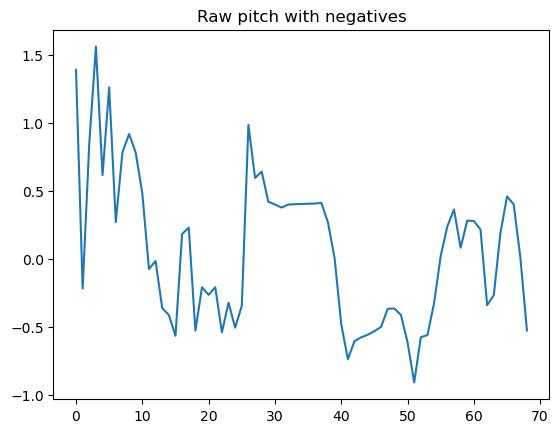

In [4]:
pitch_path = '/home/you/workspace/son/FastSpeech2/preprocessed_data/MSP_clean/pitch/1-pitch-MSP-PODCAST_0023_0044.npy'
# wav_path = '/home/you/workspace/son/FastSpeech2/raw_data/LibriTTS/5126/5126_34483_000006_000003.wav'

# pitch_path = '/home/you/workspace/son/FastSpeech2/preprocessed_data/MSP/pitch/1-pitch-MSP-PODCAST_0023_0005.npy'
import numpy as np
import matplotlib.pyplot as plt

# def normalize(self, in_dir, mean, std):
#     max_value = np.finfo(np.float64).min
#     min_value = np.finfo(np.float64).max
#     for filename in os.listdir(in_dir):
#         filename = os.path.join(in_dir, filename)
#         values = (np.load(filename) - mean) / std
#         np.save(filename, values)
#         max_value = max(max_value, max(values))
#         min_value = min(min_value, min(values))
#     return min_value, max_value
# with open(
#     os.path.join(preprocess_config["path"]["preprocessed_path"], "stats.json")
# ) as f:
#     stats = json.load(f)
#     stats = stats["pitch"] + stats["energy"][:2]
# pitch_min, pitch_max, pitch_mean, pitch_std, energy_min, energy_max = stats
# values = (np.load(filename) - mean) / std
# np.save(filename, values)

pitch = np.load(pitch_path)
print("min:", np.min(pitch))
print("neg count:", np.sum(pitch < 0))
plt.plot(pitch)
plt.title("Raw pitch with negatives")
plt.show()


In [2]:
import argparse
import numpy as np
import pyworld as pw
import librosa
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import yaml

from preprocessor.preprocessor import Preprocessor

config = '/home/you/workspace/son/FastSpeech2/config/LibriTTS/preprocess.yaml'
config = yaml.load(open(config, "r"), Loader=yaml.FullLoader)
preprocessor = Preprocessor(config)
ret = preprocessor.process_utterance('5126', '5126_34483_000006_000003')



Traceback (most recent call last):
  File "/home/you/anaconda3/envs/fs2/lib/python3.7/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_vars.py", line 620, in change_attr_expression
    value = eval(expression, frame.f_globals, frame.f_locals)
  File "<string>", line 1, in <module>
NameError: name 'array' is not defined


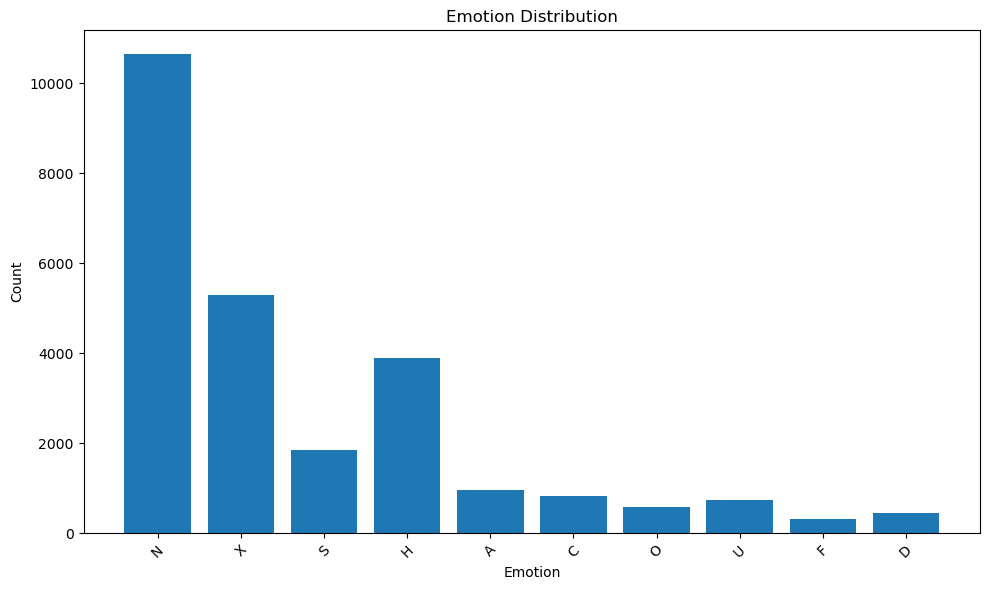


Emotion distribution:
N: 10644 (41.68%)
X: 5284 (20.69%)
S: 1858 (7.27%)
H: 3894 (15.25%)
A: 964 (3.77%)
C: 820 (3.21%)
O: 579 (2.27%)
U: 734 (2.87%)
F: 321 (1.26%)
D: 442 (1.73%)


In [2]:
import os

def process_meta(filename):
    with open(
        os.path.join('/home/you/workspace/son/FastSpeech2/preprocessed_data/MSP_clean_new', filename), "r", encoding="utf-8"
    ) as f:
        name = []
        speaker = []
        text = []
        raw_text = []
        emotion = []
        arousal = []
        valence = []
        for line in f.readlines():
            n, s, t, r, e, a, v = line.strip("\n").split("|")
            name.append(n)
            speaker.append(s)
            text.append(t)
            raw_text.append(r)
            emotion.append(e)
            arousal.append(a)
            valence.append(v)
        return name, speaker, text, raw_text, emotion, arousal, valence
_, _, _, _, emotion, arousal, valence = process_meta('train.txt')
from collections import Counter
import matplotlib.pyplot as plt

# 统计情感标签分布
emotion_counts = Counter(emotion)

# 绘制柱状图
plt.figure(figsize=(10,6))
plt.bar(emotion_counts.keys(), emotion_counts.values())
plt.title('Emotion Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nEmotion distribution:")
for emo, count in emotion_counts.items():
    print(f"{emo}: {count} ({count/len(emotion)*100:.2f}%)")

    